In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline	

## Pre-processing

In [2]:
columns = ['timestamp', 'arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']

df = pd.read_csv("post-attack-labeled/rpm-attacks/rpm-1.csv", sep=",", index_col=None)


# Function to split each value into 8 bytes
def split_bytes(value):
    bytes_list = [value[i:i+2] for i in range(0, len(value), 2)]
    return bytes_list

# Apply the function to create new columns
df_bytes = df['data_field'].apply(split_bytes).apply(pd.Series)

# Rename columns
df_bytes.columns = [f'byte_{i+1}' for i in range(df_bytes.shape[1])]

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, df_bytes], axis=1)


# Drop data_field
df = df.drop(["data_field"], axis= 1)

# Set new order to columns with attack label last
df = df[columns]


for i in columns:
    if i == 'attack':
        continue
    df[i] = df[i].astype(str).dropna().apply(lambda x: float.fromhex(x))

# Replace NaN values with 0
df.fillna(0, inplace=True)

df


,timestamp,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,9.640733e+10,2.0,255.0,247.0,112.0,9.0,111.0,0.0,0.0,0.0,0
1,9.640733e+10,117.0,0.0,0.0,0.0,0.0,0.0,9.0,8.0,244.0,0
2,9.640733e+10,208.0,2.0,0.0,1.0,0.0,5.0,40.0,0.0,253.0,0
3,9.640733e+10,209.0,214.0,7.0,0.0,128.0,0.0,0.0,0.0,0.0,0
4,9.640733e+10,210.0,0.0,0.0,255.0,255.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
488523,9.640733e+10,328.0,11.0,17.0,17.0,132.0,65.0,0.0,17.0,5.0,0
488524,9.640733e+10,329.0,104.0,1.0,63.0,130.0,170.0,48.0,0.0,0.0,0
488525,9.640733e+10,872.0,4.0,0.0,0.0,134.0,0.0,0.0,0.0,0.0,0
488526,9.640733e+10,1785.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
df['attack'].value_counts()

attack
0    483698
1      4830
Name: count, dtype: int64

In [4]:
train_cols = ['arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8']

# Scale

In [5]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 
    else:
        if col == 'attack' or col == 'timestamp':
            continue 
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        encoder_map[col] = scaler 


# Train-test split

In [6]:
labels = df['attack']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df[train_cols].values, labels.values, test_size = 0.15, random_state = 42)

In [7]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(332198, 9)
y_train:(332198,)

x_val:(83050, 9)
y_val:(83050,)

x_test:(73280, 9)
y_test:(73280,)


In [11]:
# Split a set into 80% only normal data, and 20% normal data + any anomalies in set
def split_by_class(x, y):
    # Separate into normal, anomaly
    x_normal = x[y == 0]
    x_anom = x[y==1]
    
    y_normal = y[y==0]
    y_anom = y[y==1]
    
    # Split normal into 80-20 split, one for pure training and other for eval
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_normal, y_normal, test_size=0.2, random_state=42)
    
    # Combine the eval set with the anomalies to test outlier detection
    x_train_test = np.concatenate((x_train_test, x_anom))
    y_train_test = np.concatenate((y_train_test, y_anom))
    
    # Shuffle the eval set
    random_indices = np.random.choice(list(range(len(x_train_test))), size=len(x_train_test), replace=False)
    x_train_test = x_train_test[random_indices]
    y_train_test = y_train_test[random_indices]
    
    return x_train_train, x_train_test, y_train_train, y_train_test

In [12]:
### Train on normal data only. The _test splits have normal and anomaly data both
x_train_train, x_train_test, y_train_train, y_train_test = split_by_class(x_train, y_train)

In [13]:
x_train_test

array([[-0.17428367, -0.70012654, -0.62751527, ..., -0.61401835,
        -0.41391178, -0.60325871],
       [-0.27314957, -0.28687695, -0.04108773, ...,  2.67267327,
         0.47443509, -0.57190638],
       [-0.25217801, -0.57385583, -0.25713998, ..., -0.61401835,
         1.06666633, -0.52487789],
       ...,
       [ 1.41356253,  0.10341433, -0.50405684, ..., -0.61401835,
        -0.52300701, -0.60325871],
       [-0.2761455 , -0.12616878, -0.45775993, ...,  0.16615592,
         0.31858476, -0.10162148],
       [ 2.95347376, -0.70012654, -0.62751527, ...,  0.01676085,
         0.0536392 , -0.07026915]])

In [14]:
print(f"x_train_train: {x_train_train.shape}")
print(f"y_train_train: {y_train_train.shape}")   
print(f"x_train_test: {x_train_test.shape}") 
print(f"y_train_test: {y_train_test.shape}") 

x_train_train: (263152, 9)
y_train_train: (263152,)
x_train_test: (69046, 9)
y_train_test: (69046,)


## One-Class SVM

In [15]:
# estimate proportion of anomalies
(y_test==1).sum() / len(y_test)

0.01041211790393013

In [16]:
svm = OneClassSVM(nu=0.0065, gamma=0.05)
svm.fit(x_train_train[:])

OneClassSVM(gamma=0.05, nu=0.0065)

In [17]:
preds = svm.predict(x_train_test)
# -1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.
preds = (preds < 0).astype(int) 
preds

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
pre = precision_score(y_train_test, preds )
rec = recall_score(y_train_test, preds)
f1 = f1_score(y_train_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.0
Recall: 0.0
F1-Measure: 0.0


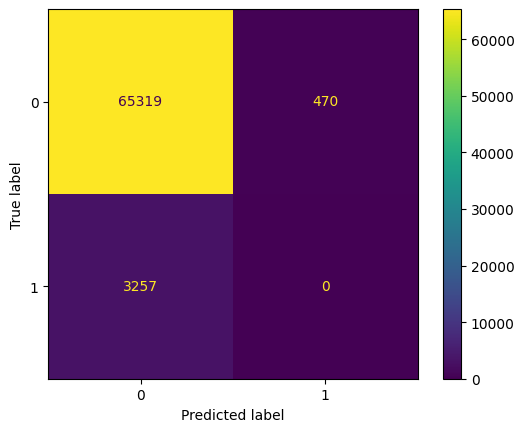

In [20]:
ConfusionMatrixDisplay(confusion_matrix(y_train_test, preds)).plot()

# Hyperparameter testing

### Gamma

In [21]:
def experiment(svm, x_train, y_train, x_test, y_test):
    
    # Fit on the training data, predict on the test
    svm.fit(x_train)
    
    preds = svm.predict(x_test)
    
    # Predictions are either -1 or 1
    preds = (preds < 0).astype(int)
    
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    return {'precision': pre, 'recall': rec, 'f1': f1}

In [22]:
validation_results = {}
gamma = [0.005, 0.05, 0.5]
for g in gamma:

    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res
 
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.005, 0.0), (0.05, 0.0), (0.5, 0.0)]

In [23]:
validation_results = {}
gamma = [1, 5, 10, 15, 20, 100, 150, 200]
for g in gamma:
    g = g / 1000.0

    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.005, 0.0),
 (0.01, 0.0),
 (0.015, 0.0),
 (0.02, 0.0),
 (0.1, 0.0),
 (0.15, 0.0),
 (0.2, 0.0)]

In [24]:
validation_results = {}
gamma = [0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018]
for g in gamma:

    svm = OneClassSVM(nu=0.0065, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.011, 0.0),
 (0.012, 0.0),
 (0.013, 0.0),
 (0.014, 0.0),
 (0.015, 0.0),
 (0.016, 0.0),
 (0.017, 0.0),
 (0.018, 0.0)]

### nu

In [25]:

validation_results = {}
nu = range(1, 10)
for n in nu:
    n = n / 1000.0

    svm = OneClassSVM(nu=n, gamma=0.014)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.002, 0.0),
 (0.003, 0.0),
 (0.004, 0.0),
 (0.005, 0.0),
 (0.006, 0.0),
 (0.007, 0.0),
 (0.008, 0.0),
 (0.009, 0.0)]

In [26]:
validation_results = {}
nu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 15]
for n in nu:
    n = n / 100000.0

    svm = OneClassSVM(nu=n, gamma=0.014)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(1e-05, 0.0),
 (2e-05, 0.0),
 (3e-05, 0.0),
 (4e-05, 0.0),
 (5e-05, 0.0),
 (6e-05, 0.0),
 (7e-05, 0.0),
 (8e-05, 0.0),
 (9e-05, 0.0),
 (0.0001, 0.0),
 (0.00011, 0.0),
 (0.00012, 0.0),
 (0.00013, 0.0),
 (0.00015, 0.0)]

## Re-train model


In [ ]:
svm = OneClassSVM(nu=0.00005, gamma=0.016)
svm.fit(x_train_train[:])

In [57]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)

In [ ]:
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

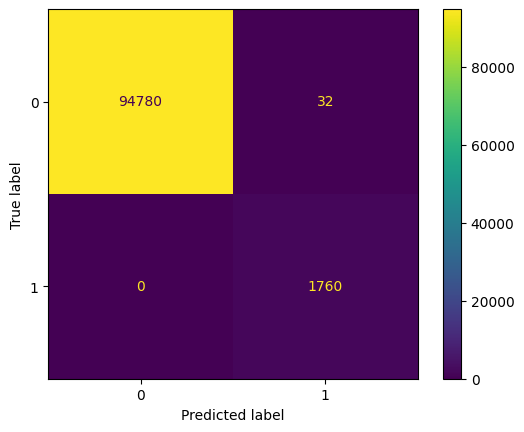

In [59]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()